In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from data_poisoning import MixedDatasetPreComputed, load_trigger_tensor, MixedDataset
from torchvision.models.vision_transformer import vit_b_16
from timm.models.vision_transformer import vit_tiny_patch16_224
from torchvision.datasets import CIFAR10
from torchsummary import summary
from copy import deepcopy
from typing import Type

BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
EPOCHS = 1
LOAD_OLD_MODEL = True
LIMIT_GPU_USAGE = True
LIMIT_MODEL_PRECISION = True

class ViTFeatureExtractor(nn.Module):
    def __init__(self):
        super(ViTFeatureExtractor, self).__init__()
        self.vit = vit_tiny_patch16_224(pretrained=True)
        self.vit.heads = nn.Identity()  # Remove the classification head to get features

    def forward(self, x):
        return self.vit(x)

pre_transform = transforms.ToTensor()

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

trigger_tensor = load_trigger_tensor("./triggers/trigger.png")

train_pre_dataset = CIFAR10(root='./data', train=True, download=True, transform=pre_transform)
test_pre_dataset = CIFAR10(root='./data', train=False, download=True, transform=pre_transform)

train_dataset = MixedDataset(train_pre_dataset, trigger_tensor, scale_factor=0.2, transform=transform)
test_dataset = MixedDataset(test_pre_dataset, trigger_tensor, scale_factor=0.2, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

c:\Users\Korisnik\anaconda3\envs\cuda_env1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


In [2]:
class ViTFeatureExtractor(nn.Module):
    def __init__(self):
        super(ViTFeatureExtractor, self).__init__()
        self.vit = vit_b_16(pretrained=True)
        self.vit.heads = nn.Linear(self.vit.heads[0].in_features, 10)
    def forward(self, x):
        return self.vit(x)

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTFeatureExtractor().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

c:\Users\Korisnik\anaconda3\envs\cuda_env1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Korisnik\anaconda3\envs\cuda_env1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
print(device)

cuda


In [ ]:
scaler = torch.cuda.amp.GradScaler()
# Fine-tuning the model
if not LOAD_OLD_MODEL:
    epochs = 1
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels, _, _ in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")


In [5]:
#LOAD OLD TRANSFORMER MODEL from vit-cifar.pth

import torch.backends
import torch.backends.cudnn


if LOAD_OLD_MODEL:
    checkpoint = torch.load('vit_cifar10_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

if LIMIT_GPU_USAGE:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [6]:
model.vit.heads = nn.Identity()
model.eval()

# Feature extraction
features = []
labels = []
poisoned_flags = []

with torch.no_grad():
    for images, labels_batch, true_labels, poisoned in tqdm(train_loader):
        images = images.to(device)
        batch_features = model(images).cpu().numpy()
        features.append(batch_features)
        labels.append(labels_batch.numpy())
        poisoned_flags.append(poisoned.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)
poisoned_flags = np.concatenate(poisoned_flags, axis=0)

# Save features and labels for future use
np.save("features.npy", features)
np.save("labels.npy", labels)

  1%|          | 247/25000 [00:07<12:34, 32.80it/s]


KeyboardInterrupt: 

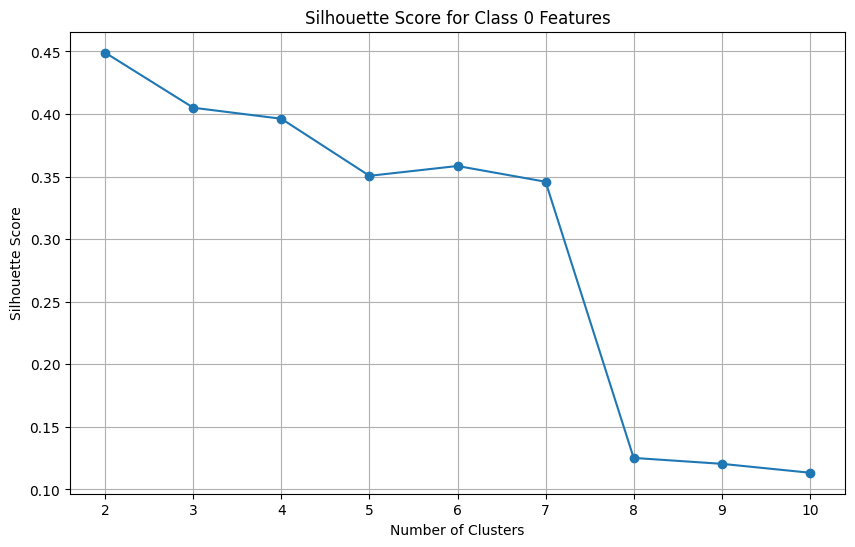

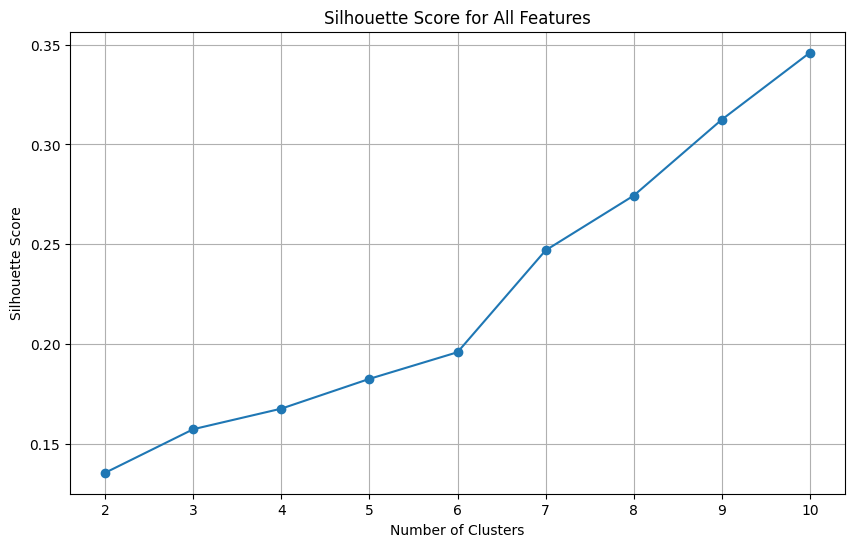

Performing t-SNE for all features...


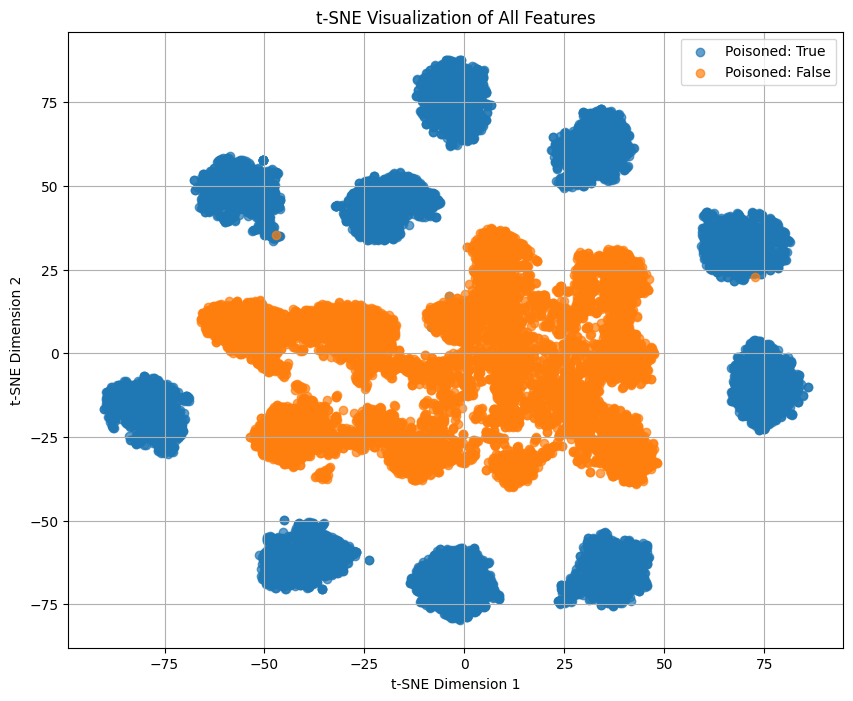

In [6]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Silhouette score analysis for label == 0
class_0_indices = labels == 0
class_0_features = features[class_0_indices]

# Silhouette analysis for label == 0
range_n_clusters = list(range(2, 11))
silhouette_scores_class_0 = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(class_0_features)
    silhouette_avg = silhouette_score(class_0_features, cluster_labels)
    silhouette_scores_class_0.append(silhouette_avg)

# Plot silhouette scores for label == 0
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores_class_0, marker='o')
plt.title("Silhouette Score for Class 0 Features")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

silhouette_scores_all = []
range_n_clusters = list(range(2, 20))
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouette_scores_all.append(silhouette_avg)

optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores_all)]

kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
optimal_cluster_labels = kmeans.fit_predict(features)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores_all, marker='o')
plt.title("Silhouette Score for All Features")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()


# t-SNE Visualization for all labels
print("Performing t-SNE for all features...")
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Plot t-SNE visualization for all labels based on poisoned flag
plt.figure(figsize=(10, 8))
for poisoned in [True, False]:
    indices = poisoned_flags == poisoned
    plt.scatter(
        tsne_results[indices, 0],
        tsne_results[indices, 1],
        label=f"Poisoned: {poisoned}",
        alpha=0.7
    )

plt.title("t-SNE Visualization of All Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid()
plt.show()


# Display the KMeans clustering results
cluster_sizes = [np.sum(cluster_labels == cluster) for cluster in range(optimal_n_clusters)]
print(f"Cluster Sizes: {cluster_sizes}")
# Visualization (optional, for 2D or 3D features)
if features.shape[1] <= 3:  # 2D or 3D visualization
    plt.figure(figsize=(8, 6))
    for cluster in range(optimal_n_clusters):
        cluster_points = features[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# Adjusted create_cleaned_dataset function
def create_cleaned_dataset(
    dataset: Type[torch.utils.data.Dataset],
    model: torch.nn.Module,
    device: torch.device,
    num_classes: int = 10
) -> torch.utils.data.Dataset:
    """
    Create a cleaned copy of the dataset by performing clustering
    and keeping only the largest cluster for each class.

    Args:
        dataset (torch.utils.data.Dataset): The original dataset.
        model (torch.nn.Module): Pretrained model for feature extraction.
        device (torch.device): Device to use for computations (GPU recommended).
        num_classes (int): Number of classes in the dataset.

    Returns:
        torch.utils.data.Dataset: A cleaned copy of the dataset.
    """
    cleaned_dataset = deepcopy(dataset)
    model.to(device)
    model.eval()

    features_by_class = {i: [] for i in range(num_classes)}
    indices_by_class = {i: [] for i in range(num_classes)}
    deleted_poison_count = 0

    # Extract features for all data points
    with torch.no_grad():
        for idx, (image, label, _, _) in enumerate(dataset):
            image = image.unsqueeze(0).to(device)
            features = model.extract_features(image).view(-1).cpu().numpy()
            features_by_class[label].append(features)
            indices_by_class[label].append(idx)

    print(features.shape)
    # Perform clustering and keep the largest cluster
    indices_to_remove = []
    for class_label in tqdm(range(num_classes), desc="Cleaning the dataset"):
        features = np.array(features_by_class[class_label])
        indices = indices_by_class[class_label]

        if len(features) < 2:
            continue

        # Perform KMeans clustering with the optimal number of clusters
        kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(features)

        # Identify the largest cluster
        cluster_sizes = [np.sum(cluster_labels == cluster) for cluster in range(optimal_n_clusters)]
        largest_cluster = np.argmax(cluster_sizes)

        # Identify indices not in the largest cluster
        for idx, cluster in zip(indices, cluster_labels):
            if cluster != largest_cluster:
                indices_to_remove.append(idx)
                if dataset[idx][3] == True:
                    deleted_poison_count += 1
                    print(f"Poisoned images removed: {deleted_poison_count}", flush=True)

    indices_to_remove.sort(reverse=True)
    cleaned_dataset.remove_images(indices_to_remove)
    print(f"{len(indices_to_remove)} images removed from the dataset")
    print(f"Number poisonous: {deleted_poison_count}")

    return cleaned_dataset

In [ ]:
from record_utils import RecordManager
from evaluation import evaluate_and_save_metrics, pack_confidence_boxplot_metrics_to_dict, plot_confidence1d, pack_metrics_to_dict, plot_and_save_graph_from_dict

CHECKPOINT_FOLDER_PATH = "./checkpoints"
record_manager = RecordManager(CHECKPOINT_FOLDER_PATH)
SAVE_MODEL = False
SAVE_METRICS = False


def train_model(model, train_loader, test_loader, optimizer,criterion, device, EPOCHS=EPOCHS, CHECKPOINT_FOLDER_PATH=CHECKPOINT_FOLDER_PATH, SKIP_TRAIN=False, save_confidence_distribution=False, record_manager=None):
    if LOAD_OLD_MODEL:
        checkpoint = torch.load('./checkpoints/cifar/checkpoint_4.1.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_test_accuracy = 0.0
    early_stopping_condition = False

    for epoch in range(EPOCHS):
        if SKIP_TRAIN:
            break
        model.train()
        running_loss = 0.0
        total_correct = 0
        total_samples = 0
        for inputs, labels, original_label, poisoned in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)


        accuracy = total_correct / total_samples

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader)}, Train accuracy: {accuracy* 100:.2f}%")

        total_correct = 0
        total_samples = 0
        correct_poisoned = 0
        total_poisoned = 0
        correct_clean = 0
        total_clean = 0
        correct_true = 0
        total_all = 0 

        if epoch >= 0 and epoch <= 2 and save_confidence_distribution:
            metrics = pack_metrics_to_dict(test_loader, model, criterion, device)    
            plot_and_save_graph_from_dict(
                data_dict={
                    'Clean Examples': metrics['confidence']['clean'],
                    'Unlearnable Examples': metrics['confidence']['unlearnable'],
                    'All Examples': metrics['confidence']['all']
                },
                title='Confidence Distribution Across Test Data (Epoch 1)',
                xlabel='Confidence',
                filename=f"./confidence_distribution_epoch_{epoch}.png"
            )

            boxplot_metrics = pack_confidence_boxplot_metrics_to_dict(test_loader, model, criterion, device)
            plot_confidence1d(boxplot_metrics, epoch, "./", plot="BOX")
            plot_confidence1d(boxplot_metrics, epoch, "./", plot="VIOLIN")

        for inputs, labels, true_labels, poisoned in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            total_correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)

            # Separate calculations for poisoned (label != true_label) and clean (label == true_label) images
            for i in range(labels.size(0)):
                correct_true += predicted[i].eq(true_labels[i]).item()
                total_all += 1
                if labels[i] != true_labels[i]:  # Poisoned image
                    correct_poisoned += predicted[i].eq(labels[i]).item()
                    total_poisoned += 1
                else:  # Clean image
                    correct_clean += predicted[i].eq(labels[i]).item()
                    total_clean += 1


        evaluate_and_save_metrics(model, optimizer, train_loader, record_manager, running_loss, epoch, train_accuracy=accuracy,correct_true=correct_true, total_all=total_all,
                                    total_correct=total_correct, total_samples=total_samples, total_poisoned=total_poisoned, correct_poisoned=correct_poisoned, total_clean=total_clean, 
                                    correct_clean=correct_clean, best_test_accuracy=best_test_accuracy, SAVE_MODEL=SAVE_MODEL, SAVE_METRICS=SAVE_METRICS)

        print("Total correct: ", total_correct, "out of", total_samples)
        print("Test accuracy: ", (total_correct/total_samples) * 100, "%")
        if early_stopping_condition:
            print("Early stopping condition met. Stopping training.")
            break

    record_manager.save_checkpoint(model, optimizer, running_loss, train_accuracy=accuracy, test_accuracy=best_test_accuracy, epoch=epoch)


In [ ]:
from torch.utils.data import DataLoader
cleaned_dataset = create_cleaned_dataset(train_dataset, model, device, num_classes=10)

cleaned_loader = DataLoader(cleaned_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
from models import TriggerSensitiveVGG
import torch.nn as nn

model = TriggerSensitiveVGG().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_model(model=model, train_loader=cleaned_loader, test_loader=test_loader, optimizer=optimizer, criterion=criterion, device=device, EPOCHS=3, record_manager=record_manager)

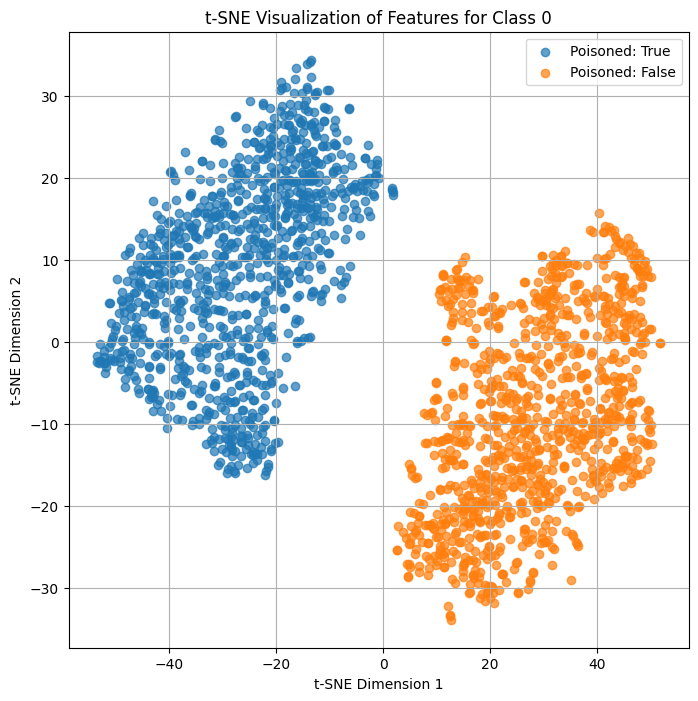

In [7]:
class_viewed = 0

class_0_indices = labels == class_viewed
class_0_features = features[class_0_indices]
class_0_poisoned_flags = poisoned_flags[class_0_indices]

# Perform t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(class_0_features)

# Plot t-SNE visualization
plt.figure(figsize=(8, 8))
for poisoned in [True, False]:
    indices = class_0_poisoned_flags == poisoned
    plt.scatter(
        tsne_results[indices, 0],
        tsne_results[indices, 1],
        label=f"Poisoned: {poisoned}",
        alpha=0.7
    )

plt.title(f"t-SNE Visualization of Features for Class {class_viewed}")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid()
plt.show()

In [8]:
from data_poisoning import PoisonousTestDataset, PoisonousTrainDataset
from torch.utils.data import DataLoader


test_pre_dataset = CIFAR10(root='./data', train=False, download=False)

adatest_dataset = PoisonousTestDataset(test_pre_dataset, trigger_tensor, scale_factor=0.2, transform=transform)
adatest_loader =  DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

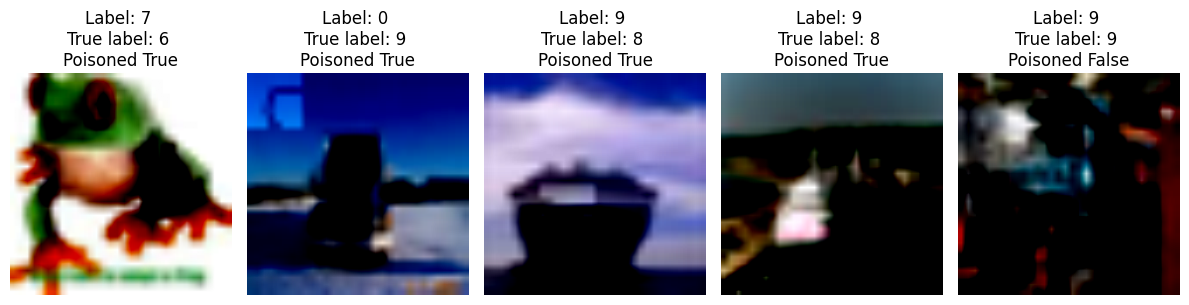

In [10]:
data_iter = iter(test_loader)
images, labels, true_labels, poisoned = next(data_iter)

# Function to display images
def show_images(images, labels, n=5):
    fig, axes = plt.subplots(1, n, figsize=(12, 4))
    images = images.permute(0, 2, 3, 1)
    for i in range(n):
        image = images[i].squeeze(0)  # Remove channel dimension for grayscale
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {labels[i].item()} \nTrue label: {true_labels[i].item()} \nPoisoned {poisoned[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display 5 images
show_images(images, labels, n=5)

In [11]:
model.vit.heads = nn.Identity()
model.eval()

# Feature extraction
features = []
labels = []
poisoned_flags = []

with torch.no_grad():
    for images, labels_batch, true_labels, poisoned in tqdm(test_loader):
        images = images.to(device)
        batch_features = model(images).cpu().numpy()
        features.append(batch_features)
        labels.append(labels_batch.numpy())
        poisoned_flags.append(poisoned.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)
poisoned_flags = np.concatenate(poisoned_flags, axis=0)

100%|██████████| 625/625 [04:09<00:00,  2.50it/s]


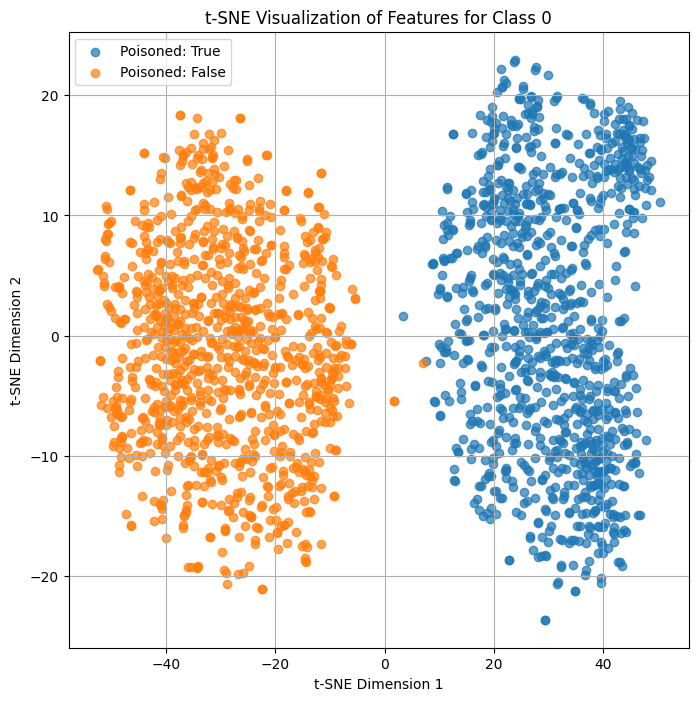

In [12]:
class_viewed = 0

class_0_indices = labels == class_viewed
class_0_features = features[class_0_indices]
class_0_poisoned_flags = poisoned_flags[class_0_indices]

# Perform t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(class_0_features)

# Plot t-SNE visualization
plt.figure(figsize=(8, 8))
for poisoned in [True, False]:
    indices = class_0_poisoned_flags == poisoned
    plt.scatter(
        tsne_results[indices, 0],
        tsne_results[indices, 1],
        label=f"Poisoned: {poisoned}",
        alpha=0.7
    )

plt.title(f"t-SNE Visualization of Features for Class {class_viewed}")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid()
plt.show()